In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from sklearn.model_selection import train_test_split, KFold
# save the final model to file
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.models import load_model

In [6]:
def normalize(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
def loadData():
    listImagePaths=glob('characterdata/0/*.jpg')
    listLabel=os.listdir('characterdata/')
    listImages=[]
    labels=[]
    maplabel={'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9}
    for label in maplabel.keys():
        listImagePaths=glob('characterdata/'+label+'/*.jpg')
        len_listImagePath=len(listImagePaths)
        for i in range(len_listImagePath):
            img=~cv2.imread(listImagePaths[i], 0)
            d=np.abs(img.shape[0]-img.shape[1])//2
            extend=np.zeros((img.shape[0], d))
            extend[:,:] = (np.min(img)+np.average(img))//2
            img=np.hstack((img, extend))
            img=np.hstack((extend, img))
            img=cv2.resize(img, (30,30))
            labels.append(maplabel[label])
            listImages.append(img)
    listImages=np.asarray(listImages)
    labels=np.asarray(labels)
    listImages=listImages.reshape(listImages.shape[0], 30,30,1)
    X_train, X_test, y_train, y_test = train_test_split(listImages, labels, test_size=0.2)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    # normalize
    return (X_train, X_test, y_train, y_test)
def imshow(img):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap='gray')
    plt.show()
# define cnn model

def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(30, 30, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	# model.summary()
	return model
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	i=0
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		model.save('model_number_'+str(i)+'.h5')
		i=i+1
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(3, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(3, 1, 3)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX,testX, trainY, testY = loadData()
	# prepare pixel data
	trainX, testX = normalize(trainX, testX)
	# define model
	scores, histories = evaluate_model(trainX, trainY)
	summarize_diagnostics(histories)
	# model=define_model()
	#fit model
	# print(trainY.shape)
	# print(trainX.shape)
	# model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
	# save model
	# model.save('number_model.h5')

In [4]:
trainX,testX, trainY, testY = loadData()
# prepare pixel data
trainX, testX = normalize(trainX, testX)
# define model
scores, histories = evaluate_model(trainX, trainY)


> 99.211
> 99.575
> 99.818
> 99.575
> 99.636


<ipython-input-6-25412abcb68b>:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(3, 1, 1)
<ipython-input-6-25412abcb68b>:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(3, 1, 3)


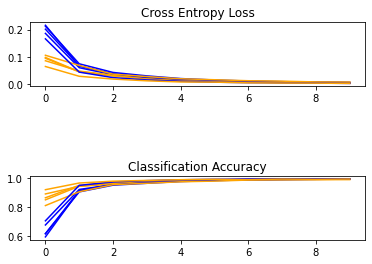

In [7]:
import matplotlib.pyplot as pyplot
summarize_diagnostics(histories)

In [8]:
model=load_model('model_number_2.h5')
_, acc=model.evaluate(testX, testY, verbose=0)
print("%.3f" %(acc*100.0))
# for i in testX[:24]:
#     extend=np.abs(i.shape[0]-i.shape[1])//2
#     print(i.shape)
#     np.zeros(())
    # image = cv2.copyMakeBorder(i, 0, 0,extend , extend, cv2.BORDER_CONSTANT, np.mi
    # model=load_model('model_number_2.h5')
    # digit=model.predict_classes(i.reshape(1,30,30,1))
    # print(digit)

99.175


In [ ]:
listImagePaths=glob('characterdata/0/*.jpg')
listLabel=os.listdir('characterdata/')
listImages=[]
labels=[]
maplabel={'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9}
for label in maplabel.keys():
    listImagePaths=glob('characterdata/'+label+'/*.jpg')
    len_listImagePath=len(listImagePaths)
    for i in range(len_listImagePath)[:30]:
        img=~cv2.imread(listImagePaths[i], 0)
        d=np.abs(img.shape[0]-img.shape[1])//2
        extend=np.zeros((img.shape[0], d))
        extend[:,:] = (np.min(img)+np.average(img))//2
        img=np.hstack((img, extend))
        img=np.hstack((extend, img))
        img=cv2.threshold(img, 140,255, cv2.THRESH_BINARY)[1]
        # print(extend)
        # plt.imshow(img, cmap='gray')
        # plt.show()